### Project Description

The gym chain Model Fitness is developing a customer interaction strategy
based on analytical data.
One of the most common problems gyms and other services face is customer
churn. How do you know if a customer is no longer with you? 

For a gym, it makes sense to say a customer has left if they don't come for a
month. Of course, it's possible they're in Cancun and will resume their visits
when they return, but's that's not a typical case. Usually, if a customer joins,
comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness digitized a number of customer profiles.
Your task is to analyze them and come up with a customer retention strategy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Step 1. Download the data

In [2]:
# read the data on the customers from the CSV file
gym = pd.read_csv('datasets/gym_churn_us.csv')

In [3]:
gym.shape

(4000, 14)

In [4]:
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

### Step 2. Carry out exploratory data analysis (EDA)  

#### Look at the dataset: does it contain any missing features? Study the mean values and standard deviation (use the describe() method).

In [6]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


##### Conclusion:
Half of the gym members only have a 1 month contract.

contract period = 1
month to end contract = 1
churn = very high
maybe a special offer? first month free?

Obviously, the one month offer works to get the customers in the door.
Keeping the customer after the first month needs to be the focus.

There are no 3 month contracts. Why not?

In [7]:
gym['Contract_period'].value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

#### Look at the mean feature values in two groups: for those who left (churn) and for those who stayed (use the groupby() method).

In [8]:
gym['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

#### Plot bar histograms and feature distributions for those who left (churn) and those who stayed.

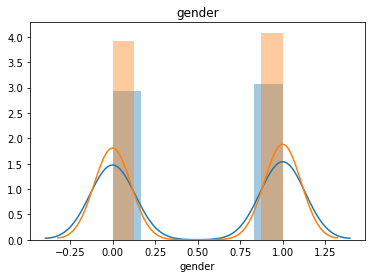

Near_Location


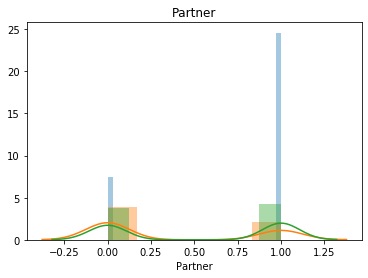

Promo_friends
Phone
Contract_period


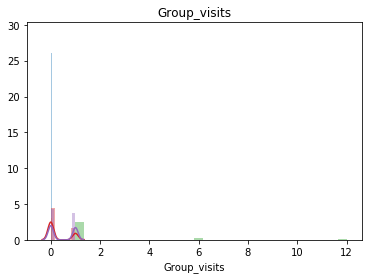

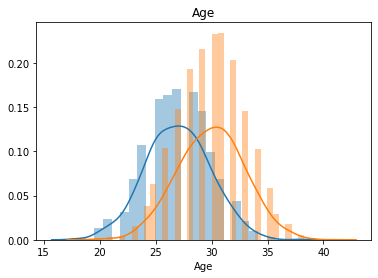

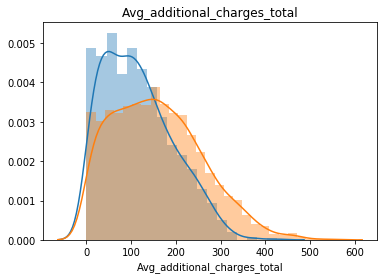

Month_to_end_contract


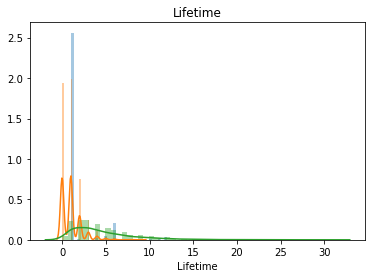

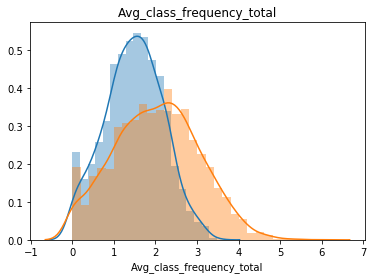

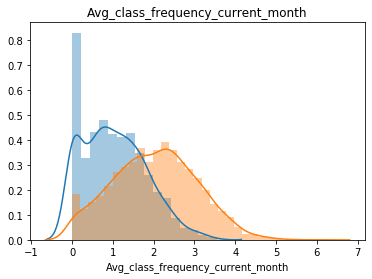

C:\Users\dodea\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\dodea\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


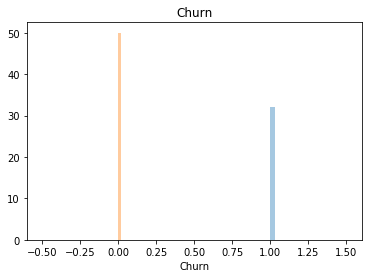

In [9]:
for feature in gym.columns:
    try:
        sns.distplot(gym.query('Churn == 1')[feature], label = 'Lost customer')
        sns.distplot(gym.query('Churn == 0')[feature], label = 'Customer stayed')
        plt.title(feature)
        plt.show()
    except:
        print(feature)

#### Build a correlation matrix and display it.

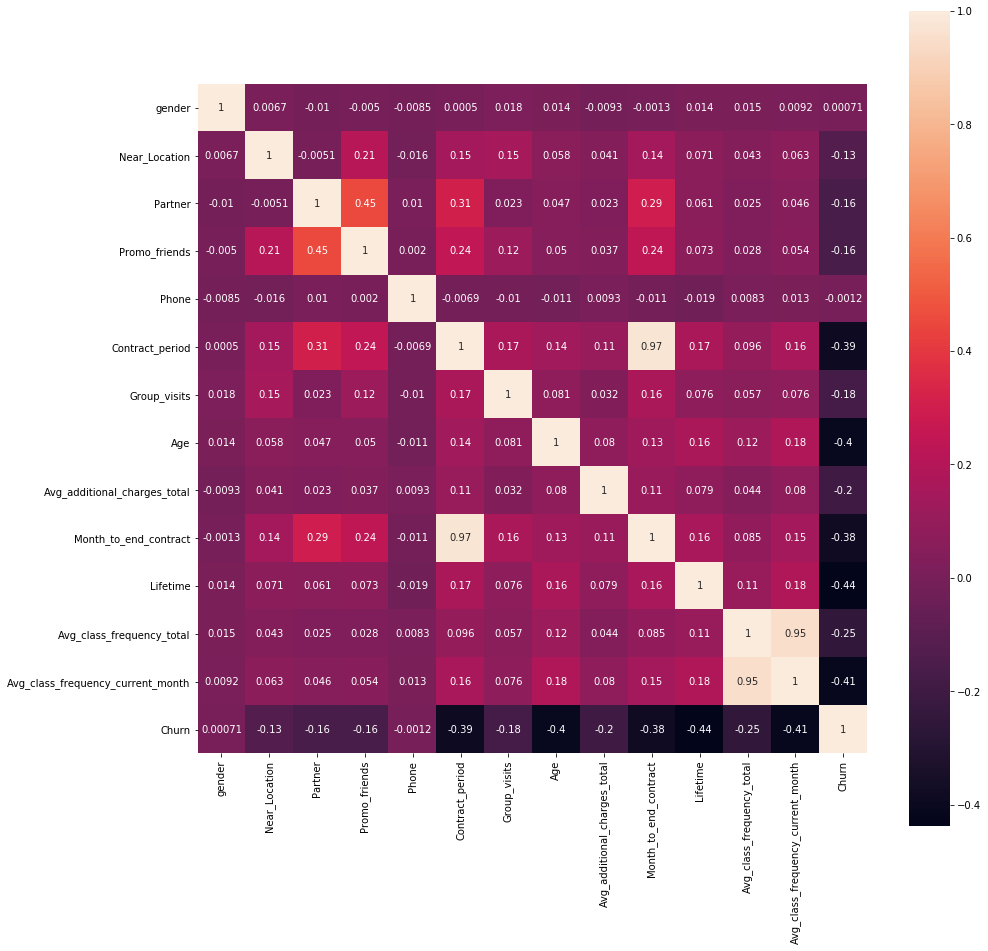

In [10]:
# correlation matrix
corr_m = gym.corr()

# plot a heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

##### Conclusion: 
Try more Promo_Friends. More likely to go with a buddy / friend. Shows a high value on heatmap.

More emphasis on Partners looks like it may pay off.

Avg_class_frequency_total and Avg_class_frequency_current_month have the same value and have a very high correlation.

### Step 3. Build a model to predict user churn

#### Build a binary classification model for customers where the target feature is the user's leaving next month.

In [11]:
# divide the data into features (the X matrix) and a target variable (y)
X = gym.drop('Churn', axis=1) 
y = gym['Churn']  

#### Divide the data into train and validation sets using the train_test_split() function.
Remember to indicate the random_state parameter when dividing data and defining the algorithm. 

In [12]:
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

<div class="alert alert-success">
    The split is done correctly
</div>

#### Train the model on the train set with two methods: 1. logistic regression

In [13]:
# train StandardScaler on the train set
scaler = StandardScaler()
scaler.fit(X_train)

# transform train and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the algorithm for the logistic regression model
lr_model = LogisticRegression()

# train the model
lr_model.fit(X_train_st, y_train)

# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

#### Train the model on the train set with two methods: 2. random forest

In [14]:
# define the algorithm for the new random forest model
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  
rf_model.fit(X_train_st, y_train)

# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] 

In [15]:
# define the function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [16]:
# print all metrics
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')

Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [17]:
# print all metrics
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


#### Evaluate accuracy, precision, and recall for both models using the validation data. Use them to compare the models. Which model gave better results?

Logistic Regression gave better results.

### Step 4. Create user clusters
Set aside the column with data on churn and identify object (user) clusters:

#### Standardize the data.

In [18]:
# obligatory standardization of data before passing it to the algorithm
sc = StandardScaler()
x_sc = sc.fit_transform(X)

#### Use the linkage() function to build a matrix of distances based on the standardized feature matrix and plot a dendrogram. Note: rendering the dendrogram may take time! Use the resulting graph to estimate the number of clusters you can single out.

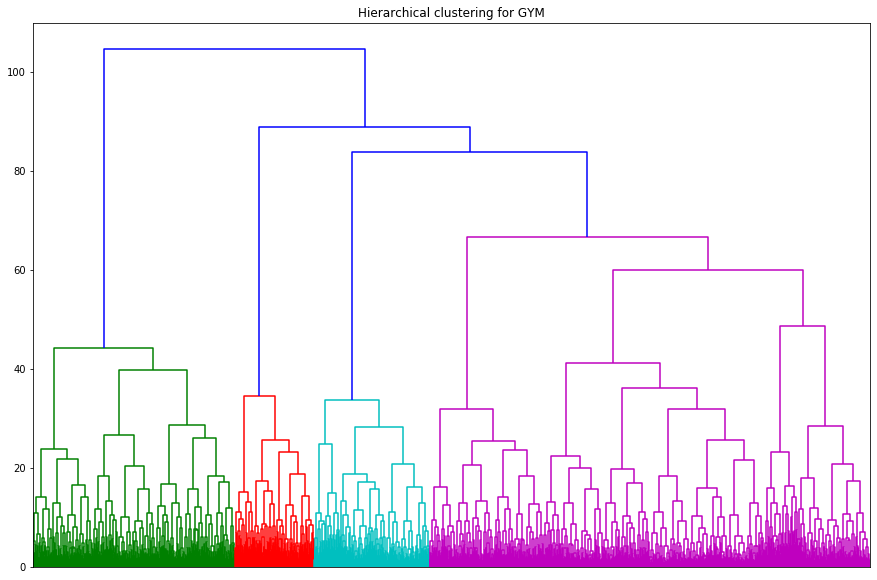

In [19]:
#First we'll standardize the data and pass the resulting table as a parameter to the linkage() function. 
#To make our plot more representative, we'll pass 'ward' to the method parameter:
linked = linkage(x_sc, method = 'ward')

#The variable linked stores the table with the linked bundles of objects. It can be visualized as a dendrogram:

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Hierarchical clustering for GYM')
plt.show()


##### Conclusion:
Setting the number of clusters to be n=5 would draw the dotted line through the 60 mark.

#### Train the clustering model with the K-means algorithm and predict customer clusters. (Let the number of clusters be n=5, so that it'll be easier to compare your results with those of other students. However, in real life, no one will give you such hints, so you'll have to decide based on the graph from the previous step.)

In [20]:
# define the k_means model with 5 clusters
km = KMeans(n_clusters = 5) # setting the number of clusters as 5

# predict the clusters for observations (the algorithm assigns them a number from 0 to 2)
labels = km.fit_predict(x_sc) # applying the algorithm to the data and forming a cluster vector

# store cluster labels in the field of our dataset
gym['cluster_km'] = labels

#### Look at the mean feature values for clusters. Does anything catch your eye?

In [21]:
# print the statistics of the mean feature values per cluster
clusters_gym = gym.groupby('cluster_km').mean()
clusters_gym

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.484921,1.000000,0.350794,0.238095,1.000000,1.953968,0.341270,28.167460,131.516081,1.861905,2.431746,1.246646,1.011770,0.515079
1,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881742,9.983051,4.748754,1.977676,1.970029,0.027916
2,0.559622,0.976387,0.360094,0.237308,0.998819,2.687131,0.469894,30.109799,161.594478,2.478158,4.890201,2.847678,2.846030,0.067296
3,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
4,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564


##### Conclusion:
Month_to_end_contract and Contract_period clusters show a nearly identical pattern to each other and large variation within the clusters.

Avg_class_frequency_total and Avg_class_frequency_current_month clusters are also nearly identical to each other, so it seems reasonable that predicting for future months could be based on Avg_class_frequency_total.

Most other features have a strong similarity between clusters within the Feature. No particular factors stand out that could influence retention.

#### Plot distributions of features for the clusters. Do you notice anything?

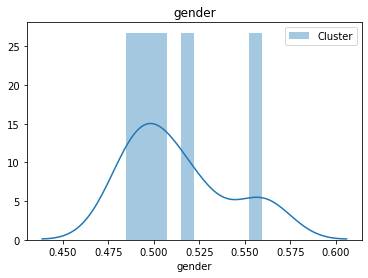

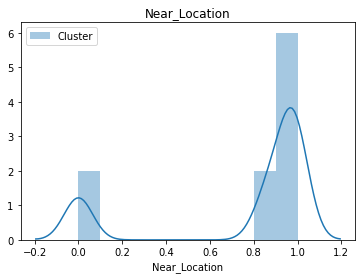

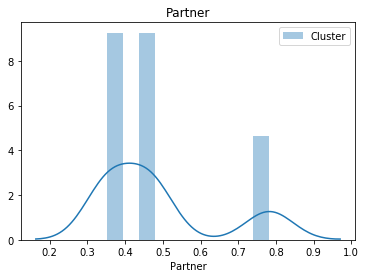

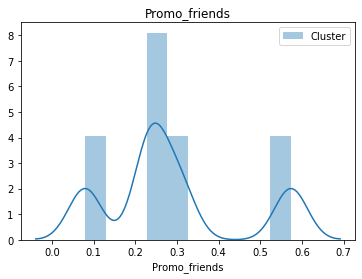

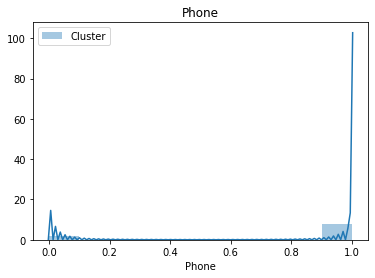

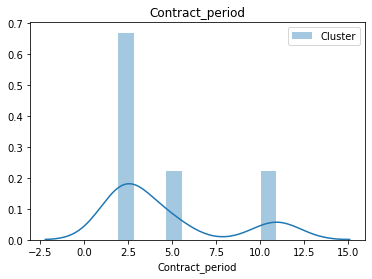

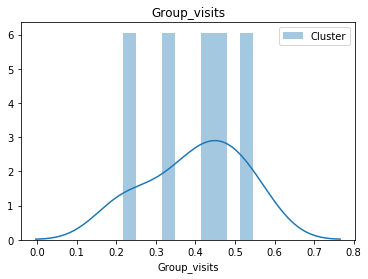

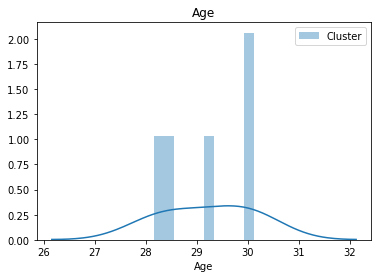

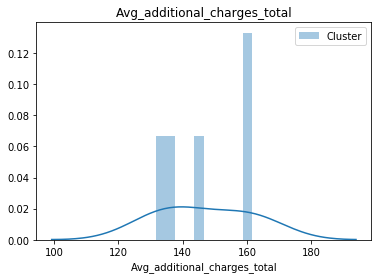

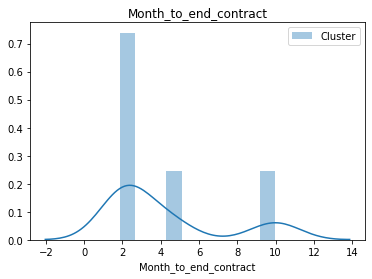

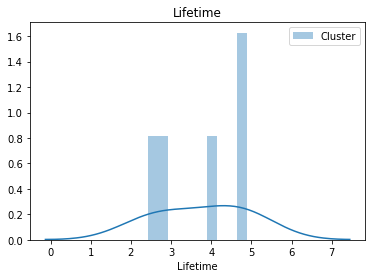

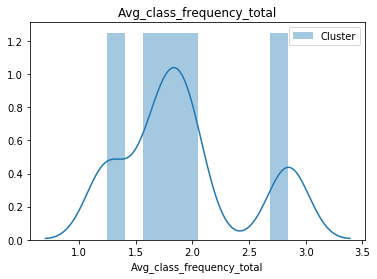

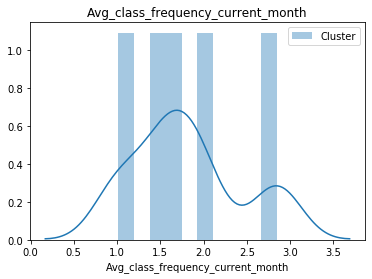

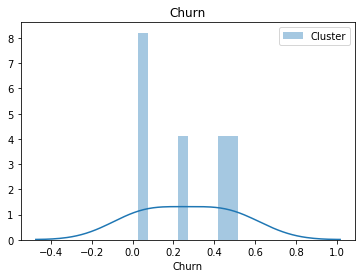

In [23]:
for feature in clusters_gym.columns:
    try:
        sns.distplot(clusters_gym[feature], bins=10, label = 'Cluster')
        plt.title(feature)
        plt.legend()
        plt.show()
    except:
        print(feature)

In [24]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (15,10))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

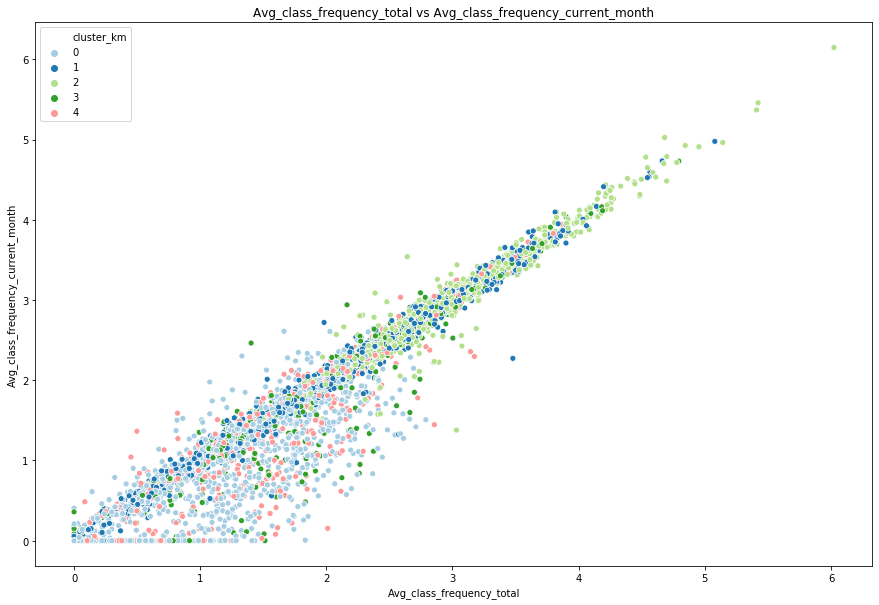

In [25]:
# render the graph for the paired "Avg_class_frequency_total" and "Avg_class_frequency_current_month" features
show_clusters_on_plot(gym,'Avg_class_frequency_total','Avg_class_frequency_current_month', 'cluster_km' ) 

##### Conclusion:
Extremely high correlation between "Avg_class_frequency_total" and "Avg_class_frequency_current_month" features.

No other pair comparisons showed this type of relationship.

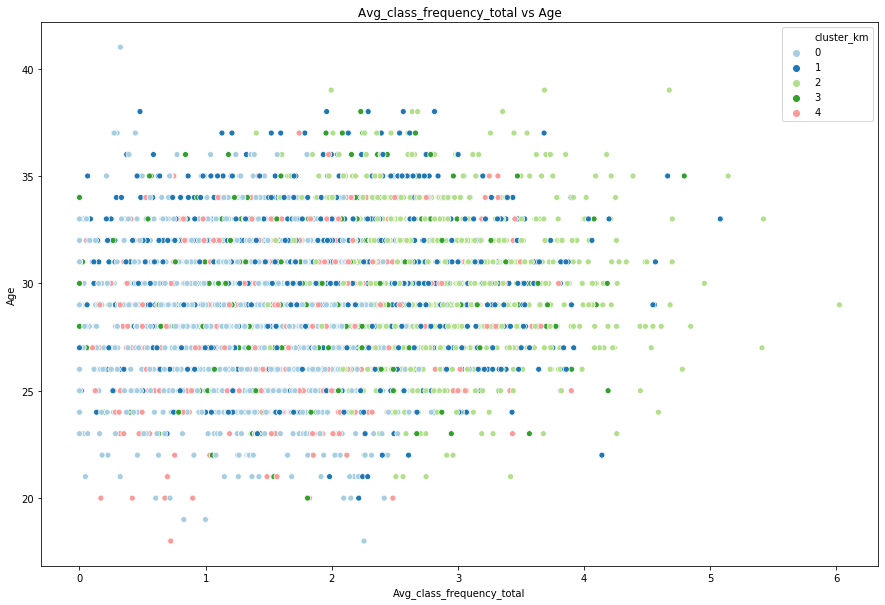

In [26]:
# render the graph for the paired "Avg_class_frequency_total" and "Age" features
show_clusters_on_plot(gym,'Avg_class_frequency_total','Age', 'cluster_km' )

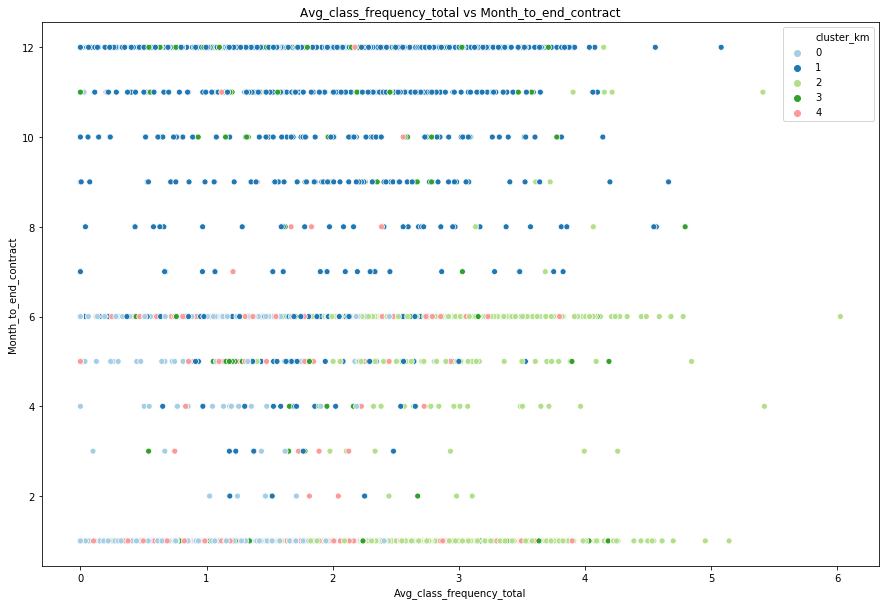

In [27]:
# render the graph for the paired "Avg_class_frequency_total" and "Month_to_end_contract" features
show_clusters_on_plot(gym,'Avg_class_frequency_total','Month_to_end_contract', 'cluster_km' )

#### Calculate the churn rate for each cluster (use the groupby() method). Do they differ in terms of churn rate? Which clusters are prone to leaving, and which are loyal?

In [29]:
# print the statistics of the mean feature values per cluster
gym.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.515079
1    0.027916
2    0.067296
3    0.267532
4    0.443564
Name: Churn, dtype: float64

Clusters 0 and 4 have the highest churn rate. The most loyal customers are in cluster number 1.

### Step 5. Come up with conclusions and basic recommendations on working with customers

Draw conclusions and formulate recommendations regarding the strategy for customer interaction and retention.
You don't need to go into detail. Three or four essential principles and examples of their implementation in the form of specific marketing steps will do.

The factor that impacts churn the most is the one month contract. There are no 3 month contracts. Why not? Maybe make a great discount for 3 months such as "Buy 2, get third month Free".

Offer more Friends & Family promo packages. It appears that if a customer is Promo_friends, they sign up for a longer  membership.

Offer more specials through employers. Partners indicates whether the user is an employee of a partner company. The employees get a discount membership, but spend the same amount in 'Avg_additional_charges_total'.

Partners also showed a correlation in the heatmap with Promo_Friends, so distributing promo coupons to the employees is bringing in new members.

'Avg_class_frequency_total' and 'Avg_class_frequency_current_month' show very high correlation in the heatmap, scatterplot, and mean feature values per cluster. It seems reasonable that predicting for future months could be based on Avg_class_frequency_total.